In [3]:
!export PATH=/opt/nvidia/hpc_sdk/Linux_x86_64/21.3/compilers/bin:$PATH

In [4]:
# import library
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
from datetime import datetime
import os
import tensorflow as tf
%matplotlib inline

In [5]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Dataset

In [6]:
dataset_dir = './Dataset/'

In [7]:
df = pd.read_csv('Dataset.csv')

In [8]:
df.shape

(3885792, 27)

In [9]:
df = df.drop_duplicates()

In [10]:
df.shape

(3780232, 27)

In [11]:
df.head()

,Dur,TotPkts,TotBytes,SrcBytes,isBotnet,StartTimeHour,StartTimeMinute,StartTimeSecond,Proto_arp,Proto_esp,...,Proto_pim,Proto_rarp,Proto_rsvp,Proto_rtcp,Proto_rtp,Proto_tcp,Proto_udp,Proto_udt,Proto_unas,isSpam
0,0.000000,1,190,190,1,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.132290,2,133,72,0,9,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3570.602295,260,19571,7824,0,9,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3595.741455,568,52954,52954,0,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3467.739746,345,147540,37595,0,9,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
df2 = df[df['isBotnet'] != 0]

In [14]:
df2.shape

(292104, 27)

In [15]:
df2.head()

,Dur,TotPkts,TotBytes,SrcBytes,isBotnet,StartTimeHour,StartTimeMinute,StartTimeSecond,Proto_arp,Proto_esp,...,Proto_pim,Proto_rarp,Proto_rsvp,Proto_rtcp,Proto_rtp,Proto_tcp,Proto_udp,Proto_udt,Proto_unas,isSpam
0,0.000000,1,190,190,1,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,44.330669,61,41484,5932,1,9,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
26,6.611188,8,1213,669,1,9,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
45,500.001709,14,5498,531,1,9,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
63,1.307856,6,366,186,1,9,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
df['isBotnet'].value_counts()

isBotnet
0    3488128
1     292104
Name: count, dtype: int64

In [16]:
df2['isSpam'].value_counts()

isSpam
0    269637
1     22467
Name: count, dtype: int64

# Modeling

## MTL

In [18]:
from sklearn.model_selection import train_test_split

# dataset 1
X_1 = df.drop(['isBotnet', 'isSpam'], axis=1)
y_1 = df['isBotnet']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_1, y_1, test_size=0.25, random_state=42
)

# dataset 2
X_1 = df2.drop(['isBotnet', 'isSpam'], axis=1)
y_1 = df2['isSpam']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_1, y_1, test_size=0.25, random_state=42
)

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

def createModel(num_features):
    # Membuat dua input layer
    input_layer_a = Input(shape=(num_features,), name='input_a')  # Dataset A (normal dan botnet)
    input_layer_b = Input(shape=(num_features,), name='input_b')  # Dataset B (hanya botnet)

    # Shared layers
    shared_layer = Dense(64, activation='relu')(input_layer_a)
    shared_layer = Dense(32, activation='relu')(shared_layer)

    # Shared layers untuk input B
    shared_layer_b = Dense(64, activation='relu')(input_layer_b)
    shared_layer_b = Dense(32, activation='relu')(shared_layer_b)

    # Menggabungkan output dari kedua shared layers
    merged = tf.keras.layers.concatenate([shared_layer, shared_layer_b])

    # Branch for Task 1 (Botnet Detection)
    botnet_output = Dense(1, activation='sigmoid', name='botnet')(merged)

    # Branch for Task 2 (Spam Detection on Botnet)
    spam_output = Dense(1, activation='sigmoid', name='spam')(merged)

    # Membangun model
    model = Model(inputs=[input_layer_a, input_layer_b], outputs=[botnet_output, spam_output])
    return model

In [37]:
# Custom loss function to apply class weights
def weighted_binary_crossentropy(class_weight):
    def loss(y_true, y_pred):
        # Calculate the binary crossentropy
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        # Apply class weights
        weight = tf.where(tf.equal(y_true, 1), class_weight[1], class_weight[0])
        return bce * weight
    return loss

In [38]:
from sklearn.utils import class_weight

# Hitung bobot kelas untuk botnet
class_weights_botnet = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_1),
    y=y_train_1
)

# Hitung bobot kelas untuk spam
class_weights_spam = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_2),
    y=y_train_2
)

# Konversi ke dictionary
class_weight_dict_botnet = {0: class_weights_botnet[0], 1: class_weights_botnet[1]}
class_weight_dict_spam = {0: class_weights_spam[0], 1: class_weights_spam[1]}

In [39]:
model = createModel(X_train_1.shape[1])
# model.compile(optimizer='adam', 
#                 loss={'botnet': 'binary_crossentropy', 'spam': 'binary_crossentropy'},
#                 metrics={'botnet': 'accuracy', 'spam': 'accuracy'})

model.compile(
    optimizer='adam',
    loss={
        'botnet': weighted_binary_crossentropy(class_weight_dict_botnet),
        'spam': weighted_binary_crossentropy(class_weight_dict_spam)
    },
    metrics=['accuracy']
)

In [41]:
# history = model.fit(X_train, 
#                     {'botnet': y_train_botnet, 'spam': y_train_spam},
#                     validation_data=(X_test, {'botnet': y_test_botnet, 'spam': y_test_spam}),
#                     epochs=5,
#                     batch_size=32)

# Melatih model
model.fit(
    [X_train_1, X_train_2], 
    {'botnet': y_train_1, 'spam': y_train_2}, 
    epochs=5, 
    batch_size=32
)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 2835174, 219078
'y' sizes: 2835174, 219078


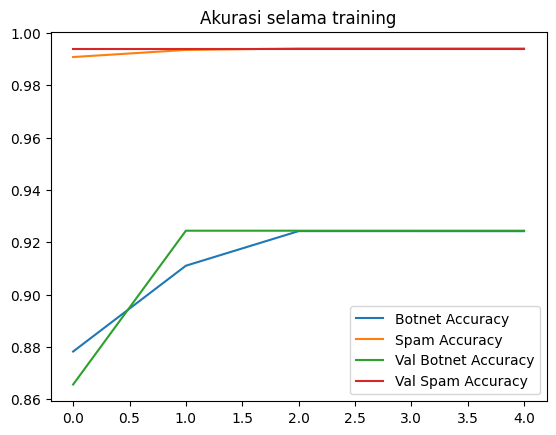

In [ ]:
# Plot akurasi
plt.plot(history.history['botnet_accuracy'], label='Botnet Accuracy')
plt.plot(history.history['spam_accuracy'], label='Spam Accuracy')
plt.plot(history.history['val_botnet_accuracy'], label='Val Botnet Accuracy')
plt.plot(history.history['val_spam_accuracy'], label='Val Spam Accuracy')
plt.title('Akurasi selama training')
plt.legend()
plt.show()

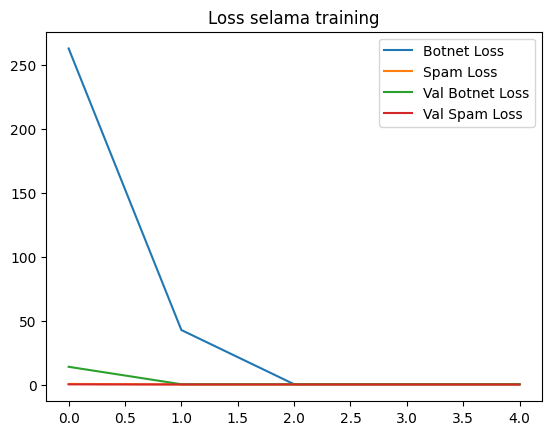

In [ ]:
# Plot loss
plt.plot(history.history['botnet_loss'], label='Botnet Loss')
plt.plot(history.history['spam_loss'], label='Spam Loss')
plt.plot(history.history['val_botnet_loss'], label='Val Botnet Loss')
plt.plot(history.history['val_spam_loss'], label='Val Spam Loss')
plt.title('Loss selama training')
plt.legend()
plt.show()

## TS-DT

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    df, test_size=0.25, random_state=42
)

In [18]:
# Train Botnet
X_train_botnet = train.drop(columns=['isBotnet', 'isSpam'])
y_train_botnet = train['isBotnet']

In [20]:
# Train Spam
X_train_spam = train[train['isBotnet'] == 1].drop(columns=['isBotnet', 'isSpam'])
y_train_spam = train[train['isBotnet'] == 1]['isSpam']

In [21]:
# Test Normal
test_normal = test[test['isBotnet'] == 0]
X_test_normal = test_normal.drop(columns=['isBotnet', 'isSpam'])
y_test_normal = test_normal['isBotnet']

In [22]:
# Test Botnet
test_botnet = test[test['isBotnet'] == 1]
X_test_botnet = test_botnet.drop(columns=['isBotnet', 'isSpam'])
y_test_botnet = test_botnet['isBotnet']

In [23]:
# Test Spam
test_spam = test[test['isSpam'] == 1]
X_test_spam = test_spam.drop(columns=['isBotnet', 'isSpam'])
y_test_spam = test_spam['isSpam']

In [24]:
pd.DataFrame(test.groupby(['isBotnet', 'isSpam']).size().reset_index(name='count'))

,isBotnet,isSpam,count
0,0,0,872250
1,1,0,67248
2,1,1,5560


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [26]:
clf1 = DecisionTreeClassifier(random_state=42)
clf1.fit(X_train_botnet, y_train_botnet)

DecisionTreeClassifier(random_state=42)

In [27]:
clf2 = DecisionTreeClassifier(random_state=42)
clf2.fit(X_train_spam, y_train_spam)

DecisionTreeClassifier(random_state=42)

In [28]:
pred = clf1.predict(X_test_botnet)

In [29]:
pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
def predictionStack(clf1, clf2, X_test, y_test):
    pred1 = clf1.predict(X_test)

    if pred1 == 1:
        

In [30]:
# Predict botnet SPAM vs non-SPAM
y_pred_second = clf2.predict(X_botnet)

In [31]:
# Evaluate the second classifier's performance
print("Second Classifier (Botnet SPAM vs Non-SPAM):")
print("Accuracy:", accuracy_score(y_botnet, y_pred_second))
print(confusion_matrix(y_botnet, y_pred_second))
print(classification_report(y_botnet, y_pred_second))

Second Classifier (Botnet SPAM vs Non-SPAM):
Accuracy: 0.999620194785817
[[ 6057     1]
 [   27 67637]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6058
           1       1.00      1.00      1.00     67664

    accuracy                           1.00     73722
   macro avg       1.00      1.00      1.00     73722
weighted avg       1.00      1.00      1.00     73722

